<a href="https://colab.research.google.com/github/Bhargavi1504/Unsupervised-algorithms/blob/main/Dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

np.random.seed(42)
n=1000

#generating base features
customer_id=[f'CUST{10000+i}' for i in range(n)]
gender=np.random.choice(['male','female','other'],size=n,p=[0.48,0.48,0.04])
ages=np.random.randint(18,70,size=n)
locations=np.random.choice(['urban','rural','sub-urban'],size=n,p=[0.5,0.3,0.2])
signup_channels=np.random.choice(['app','web','referral','email'],size=n,p=[0.4,0.3,0.2,0.1])

#sessions and purchase behaviour
total_visits=np.random.poisson(lam=20,size=n)
time_on_site = np.random.normal(loc=300,scale=100,size=n).astype(int)
avg_session_length = np.random.normal(loc=15,scale=5,size=n).clip(5,60)
total_purchases = np.random.poisson(lam=5,size=n)


#spending product preference
total_spend=(total_purchases * np.random.normal(50,20,size=n)).clip(10,3000)
favorite_category = np.random.choice(['Clothing', 'Electronics', 'Home', 'Books', 'Beauty', 'Sports'], size=n)

# 4. Returns, Coupons, Ratings
returned_items = np.random.binomial(total_purchases, p=0.1)
cart_abandon_rate = np.random.beta(2, 5, size=n).round(2)
used_coupons = np.random.poisson(3, size=n)
ratings_given = np.random.poisson(5, size=n)


# 5. Recency
last_purchase_days_ago = np.random.randint(0, 365, size=n)

#assemble to dataframe
d=pd.DataFrame({
    'Customer_ID': customer_id,
    'Gender': gender,
    'Age': ages,
    'Location': locations,
    'SignupChannel': signup_channels,
    'TotalVisits': total_visits,
    'TimeOnSite(min)': time_on_site,
    'AvgSessionLength(min)': avg_session_length,
    'TotalPurchases': total_purchases,
    'TotalSpend': total_spend.round(2),
    'FavoriteCategory': favorite_category,
    'ReturnedItems': returned_items,
    'CartAbandonRate': cart_abandon_rate,
    'UsedCoupons': used_coupons,
    'RatingsGiven': ratings_given,
    'LastPurchaseDate': last_purchase_days_ago
})

#injecting missing values
for i in ['Gender','TimeOnSite(min)','FavoriteCategory']:
  d.loc[d.sample(frac=0.02).index,i]=np.nan

#duplicates
d=pd.concat([d,d.sample(frac=0.02)],ignore_index=True)

#outliers
outlier_indices=np.random.choice(d.index,size=10,replace=False)
d.loc[outlier_indices,'TotalSpend'] *= 5
d.loc[outlier_indices,'ReturnedItems'] += 20

#display sample
print("✅ Dataset created with shape:", d.shape)
d.head()
d.to_csv('Dirty_Dataset.csv',index=False)

✅ Dataset created with shape: (1020, 16)


In [2]:
d=pd.read_csv('Dirty_Dataset.csv')

In [3]:
#Clean Dirty Dataset According to Assumptions
# Drop duplicates
d = d.drop_duplicates()

# Handle missing values

d.loc[:,'Gender']=d['Gender'].fillna('Missing')
d.loc[:,'FavoriteCategory'] = d['FavoriteCategory'].fillna('Missing')
d.loc[:,'TimeOnSite(min)'] = d['TimeOnSite(min)'].fillna(d['TimeOnSite(min)'].median())

# Drop customer ID (not a feature)
d = d.drop(columns=['Customer_ID'])


In [4]:
# Encode Categorical Columns

from sklearn.preprocessing import LabelEncoder

# Initialize encoders
enc_gender = LabelEncoder()
enc_location = LabelEncoder()
enc_signup = LabelEncoder()
enc_category = LabelEncoder()

# Apply encoding
d['Gender'] = enc_gender.fit_transform(d['Gender'])
d['Location'] = enc_location.fit_transform(d['Location'])
d['SignupChannel'] = enc_signup.fit_transform(d['SignupChannel'])
d['FavoriteCategory'] = enc_category.fit_transform(d['FavoriteCategory'])


In [5]:
# Scale the Data
from sklearn.preprocessing import StandardScaler

num_c=d.select_dtypes(include='number')

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_c)

# Optional: Turn it back into a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=num_c.columns)


Recommended min_samples: 30


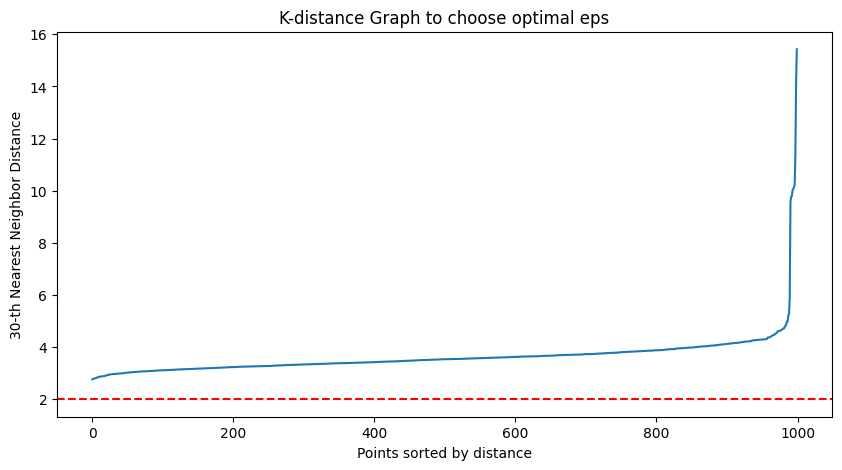

In [6]:

# k-Distance Plot (for eps estimation):

# STEP 4: Find Optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Set min_samples based on data shape
min_samples = X_scaled.shape[1] * 2  # Recommended: 2 * num_features
print("Recommended min_samples:", min_samples)

# STEP 2: K-distance plot using the same min_samples
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

k_distances = np.sort(distances[:, min_samples - 1])  # use correct k

# STEP 3: Plot
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.axhline(y=2, color='r', linestyle='--')  # Optional eyeball guess
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.title("K-distance Graph to choose optimal eps")
plt.show()


In [7]:
#model fitting
from sklearn.cluster import DBSCAN

# Try initial eps and min_samples (later we'll tune)
dbscan = DBSCAN(eps=3, min_samples=30)
clusters = dbscan.fit_predict(X_scaled)

# Attach results
d['Cluster'] = clusters


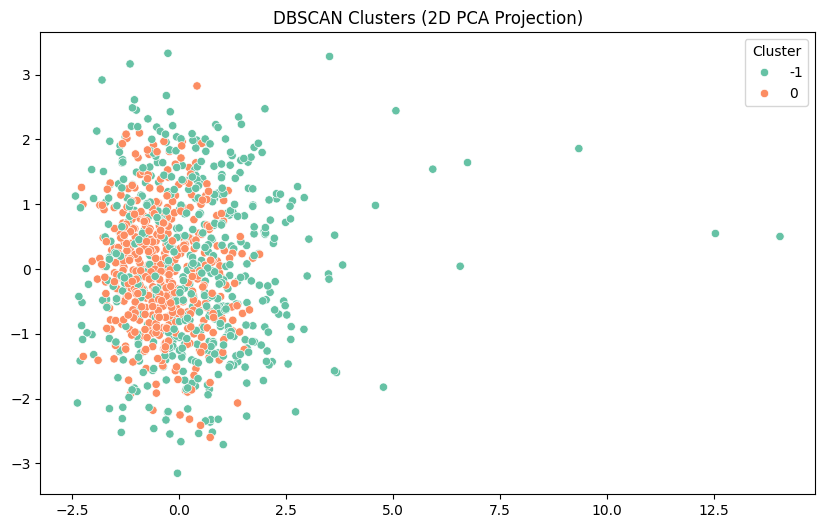

In [8]:
# Visualize DBSCAN Clusters

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=X_2D[:,0], y=X_2D[:,1], hue=d['Cluster'], palette='Set2')
plt.title("DBSCAN Clusters (2D PCA Projection)")
plt.show()


In [9]:
from sklearn.metrics import silhouette_score

# Mask for non-noise points
mask = d['Cluster'] != -1

# Count real clusters (excluding noise)
n_clusters = len(set(d['Cluster'])) - (1 if -1 in d['Cluster'].values else 0)

if n_clusters >= 2 and mask.sum() > 0:
    sil = silhouette_score(X_scaled[mask], d['Cluster'][mask])
    print("✅ Silhouette Score (ignoring noise):", round(sil, 3))
else:
    print(f"⚠️ Not enough valid clusters to compute silhouette score (only {n_clusters} found)")

# Noise ratio
noise_pct = (d['Cluster'] == -1).mean() * 100
print("🧨 Noise Percentage:", round(noise_pct, 2), "%")


⚠️ Not enough valid clusters to compute silhouette score (only 1 found)
🧨 Noise Percentage: 53.0 %


In [ ]:
from sklearn.metrics import silhouette_score

# Ignore noise (-1)
mask = d['Cluster'] != -1
if len(set(d['Cluster'])) > 1 and mask.sum() > 0:
    sil = silhouette_score(X_scaled[mask], d['Cluster'][mask])
    print("✅ Silhouette Score (ignoring noise):", round(sil, 3))
else:
    print("⚠️ Not enough clusters to compute silhouette score")

# Noise ratio
noise_pct = (d['Cluster'] == -1).mean() * 100
print("🧨 Noise Percentage:", round(noise_pct, 2), "%")


Hyperparameter tuning

In [11]:
from sklearn.metrics import silhouette_score

eps_values = [1.2, 1.5, 1.8, 2.0, 2.5]
min_samples_values = [3, 5, 8]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Compute only if multiple clusters
        if len(set(labels)) > 1 and -1 in labels:
            sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])
            noise_ratio = (labels == -1).mean() * 100
            print(f"eps={eps}, min_samples={min_samples} → Silhouette: {round(sil,2)}, Noise: {round(noise_ratio,1)}%")


eps=2.0, min_samples=3 → Silhouette: 0.3, Noise: 96.2%
eps=2.5, min_samples=3 → Silhouette: -0.07, Noise: 51.8%
eps=2.5, min_samples=5 → Silhouette: -0.09, Noise: 63.7%
eps=2.5, min_samples=8 → Silhouette: -0.01, Noise: 82.2%


In [12]:
#Anomaly Detection (Noise Points)



# Extract anomalies
anomalies = d[d['Cluster'] == -1]
print("🚨 Total anomalies detected:", anomalies.shape[0])
anomalies.head()


🚨 Total anomalies detected: 530


,Gender,Age,Location,SignupChannel,TotalVisits,TimeOnSite(min),AvgSessionLength(min),TotalPurchases,TotalSpend,FavoriteCategory,ReturnedItems,CartAbandonRate,UsedCoupons,RatingsGiven,LastPurchaseDate,Cluster
1,1,29,0,0,18,108.0,22.209712,4,177.31,1,2,0.41,6,10,247,-1
4,2,36,0,0,24,330.0,5.000000,4,102.18,3,0,0.16,2,5,282,-1
7,1,38,0,0,16,212.0,15.880752,4,226.90,0,1,0.28,2,2,341,-1
11,3,33,0,0,13,281.0,16.342968,10,309.98,2,2,0.31,2,6,63,-1
12,1,23,2,2,28,215.0,9.425889,6,153.82,1,0,0.36,2,3,240,-1


In [13]:
# Step 1: Ensure 'Cluster' is in the dataframe
assert 'Cluster' in d.columns, "Cluster column not found!"

# Step 2: Select numeric columns only (excluding Customer_ID and other strings)
numeric_cols = d.select_dtypes(include='number').columns

# Step 3: Group by cluster and compute mean only on numeric data
cluster_summary = d.groupby('Cluster')[numeric_cols].mean().round(2)

# Step 4: Also show number of customers in each cluster
cluster_summary['Count'] = d['Cluster'].value_counts().sort_index()

# Step 5: Show result
cluster_summary


,Gender,Age,Location,SignupChannel,TotalVisits,TimeOnSite(min),AvgSessionLength(min),TotalPurchases,TotalSpend,FavoriteCategory,ReturnedItems,CartAbandonRate,UsedCoupons,RatingsGiven,LastPurchaseDate,Cluster,Count
Cluster,,,,,,,,,,,,,,,,,
-1,1.55,44.02,1.13,1.44,20.15,306.82,15.06,5.60,305.20,2.86,0.98,0.30,3.23,5.09,179.74,-1.0,530
0,1.52,42.61,1.24,1.32,19.84,289.31,14.62,4.26,207.38,2.47,0.43,0.26,2.90,4.74,177.34,0.0,470


In [14]:
# Encode and scale new customer manually using same encoders/scaler
new_customer = pd.DataFrame([{
    'Gender': 'male',
    'Age': 29,
    'Location': 'urban',
    'SignupChannel': 'app',
    'TotalVisits': 20,
    'TimeOnSite(min)': 300,
    'AvgSessionLength(min)': 20,
    'TotalPurchases': 8,
    'TotalSpend': 950,
    'FavoriteCategory': 'Electronics',
    'ReturnedItems': 1,
    'CartAbandonRate': 0.05,
    'UsedCoupons': 3,
    'RatingsGiven': 4,
    'LastPurchaseDate': 15
}])

# Encode
new_customer['Gender'] = enc_gender.transform(new_customer['Gender'])
new_customer['Location'] = enc_location.transform(new_customer['Location'])
new_customer['SignupChannel'] = enc_signup.transform(new_customer['SignupChannel'])
new_customer['FavoriteCategory'] = enc_category.transform(new_customer['FavoriteCategory'])

# Scale
X_new_scaled = scaler.transform(new_customer)

# Check distance from core points
core_samples = X_scaled[dbscan.core_sample_indices_]
nn = NearestNeighbors(n_neighbors=1).fit(core_samples)
dist, idx = nn.kneighbors(X_new_scaled)

if dist[0][0] <= dbscan.eps:
    print("✅ Belongs to a known cluster")
else:
    print("🚨 New customer is likely an anomaly or outlier")


🚨 New customer is likely an anomaly or outlier


In [15]:
new_customer = pd.DataFrame([{
    'Gender': 'female',                    # More common in cluster 0 or 1
    'Age': 33,                             # Average range
    'Location': 'urban',                   # Dense area
    'SignupChannel': 'web',                # Popular channel
    'TotalVisits': 15,                     # Moderate traffic
    'TimeOnSite(min)': 250,                # Longer session
    'AvgSessionLength(min)': 17,           # Reasonable session length
    'TotalPurchases': 5,                   # Moderate purchases
    'TotalSpend': 700,                     # Moderate spender
    'FavoriteCategory': 'Clothing',        # Dense cluster
    'ReturnedItems': 0,                    # Low return rate
    'CartAbandonRate': 0.1,                # Reasonable
    'UsedCoupons': 2,                      # Used but not extreme
    'RatingsGiven': 4,                     # Average
    'LastPurchaseDate': 20                 # Recently active
}])


new_customer['Gender'] = enc_gender.transform(new_customer['Gender'])
new_customer['Location'] = enc_location.transform(new_customer['Location'])
new_customer['SignupChannel'] = enc_signup.transform(new_customer['SignupChannel'])
new_customer['FavoriteCategory'] = enc_category.transform(new_customer['FavoriteCategory'])

X_new_scaled = scaler.transform(new_customer)


core_samples = X_scaled[dbscan.core_sample_indices_]
nn = NearestNeighbors(n_neighbors=1).fit(core_samples)
dist, idx = nn.kneighbors(X_new_scaled)

print("Distance to nearest core point:", dist[0][0])
print("Epsilon threshold (eps):", dbscan.eps)

if dist[0][0] <= dbscan.eps:
    print("✅ Belongs to a known cluster")
else:
    print("🚨 New customer is likely an anomaly or outlier")


Distance to nearest core point: 2.7353509903375053
Epsilon threshold (eps): 3
✅ Belongs to a known cluster
